<font size=6><center>**cluster and plot v2**</font>

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
from src import PATH, utils
from src import leukocyte_cluster as LEUC

In [46]:
ALL = utils.read_leukocyte(PATH.leukocyte_path2)

In [47]:
ALL.shape

(3167, 23)

# LEUC analysis pipline

In [50]:
DF_filtered, statistics=LEUC.statistics_preprocess(ALL,False)

In [51]:
DF_filtered.shape

(3154, 21)

In [52]:
data = DF_filtered.iloc[:,1:].values
# ALL_tsnes = LEUC.t_sne_tuning(data,'ALL.npy')

In [53]:
data

array([[0.00213061, 0.02368475, 0.07979112, ..., 0.13960171, 0.        ,
        0.02326942],
       [0.01989705, 0.        , 0.02813154, ..., 0.07044216, 0.        ,
        0.0102447 ],
       [0.        , 0.        , 0.1447944 , ..., 0.01426458, 0.        ,
        0.02581018],
       ...,
       [0.0244859 , 0.        , 0.06698646, ..., 0.02686826, 0.        ,
        0.        ],
       [0.0012773 , 0.01408462, 0.01809473, ..., 0.10122646, 0.        ,
        0.        ],
       [0.00343222, 0.00246936, 0.0016072 , ..., 0.06228115, 0.        ,
        0.        ]])

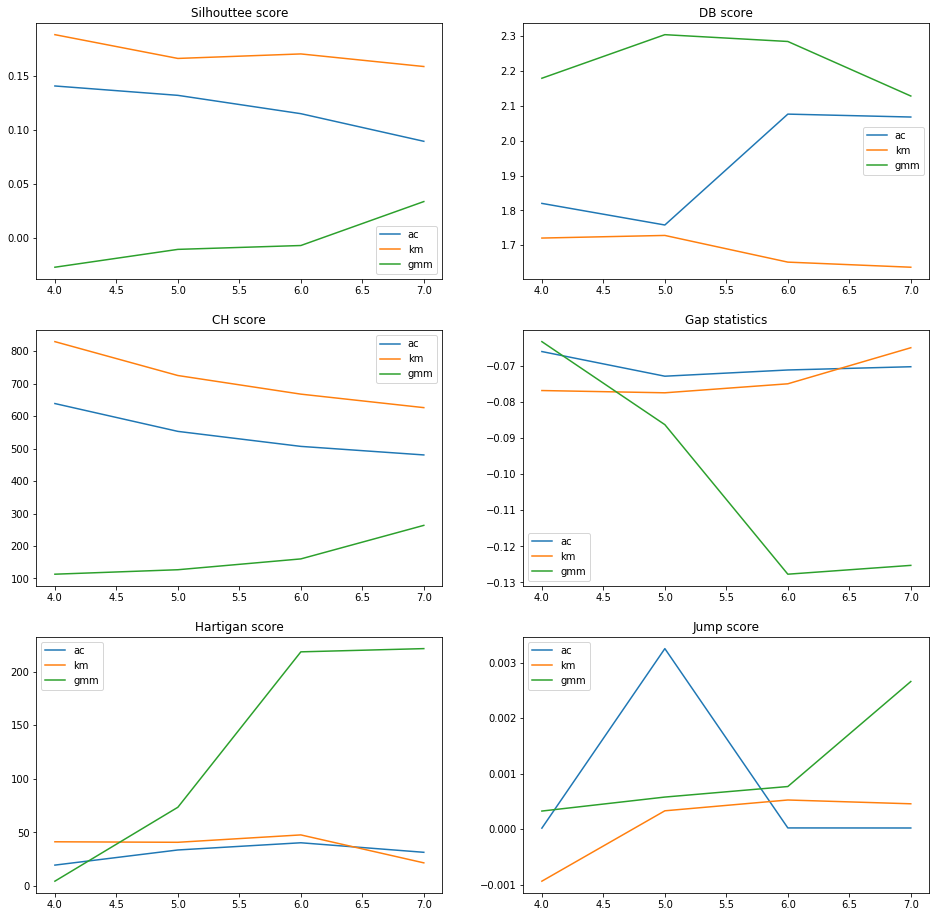

In [235]:
labels,metrics = LEUC.cluster3(data,n_clusters=range(4,9))
LEUC.metrics_curve(metrics)

/n T_SNE data exists 



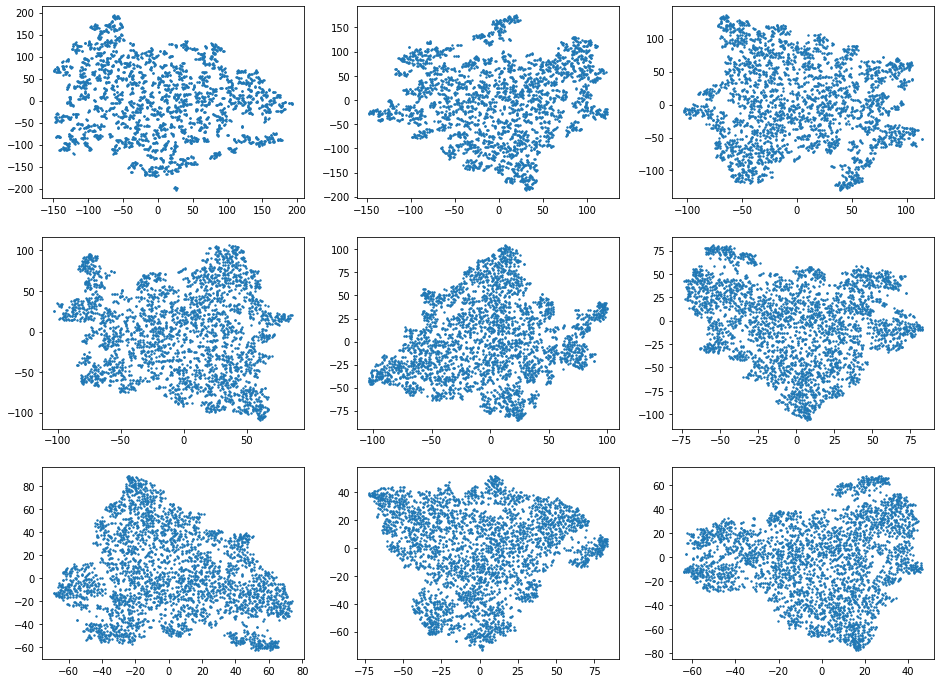

In [59]:
# v1
# ALL_tsnes = pd.read_csv(os.path.join(PATH.tsne_path,'ALL_tsne_p30.csv')).iloc[:,1:3].values
# v2
ALL_tsnes = LEUC.t_sne_tuning(data,'ALL.npy')

## try cluster in 6 group

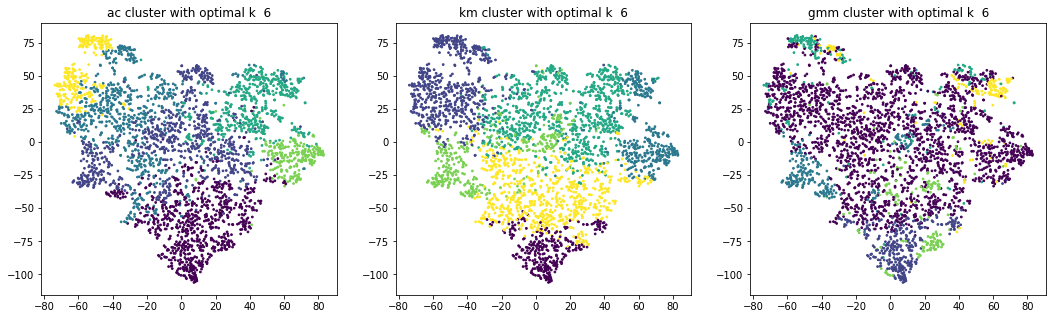

In [202]:
LEUC.t_sne_label(ALL_tsnes,labels,metrics,manual_vote=1)

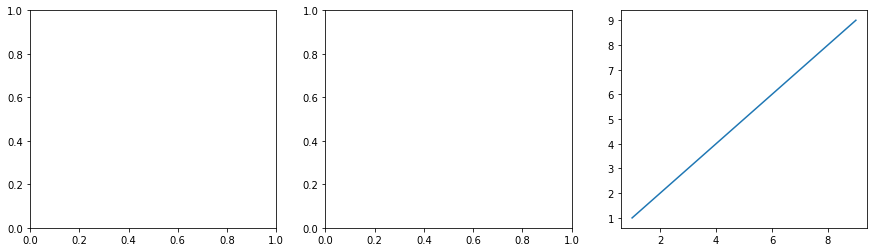

In [672]:
fig=plt.figure(figsize=(15,4))
axs = fig.subplots(1,3);
axs[2].plot(range(1,10),range(1,10))

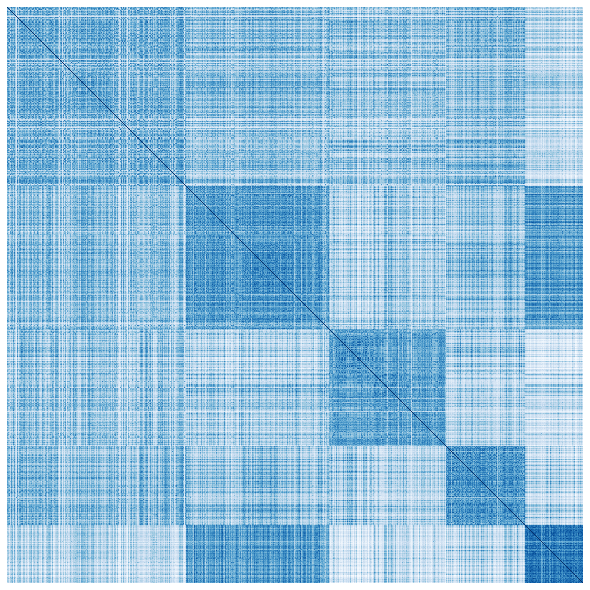

In [679]:
sorted_data,label = LEUC.sort_data_by_label(data,labels,metrics,method='km',manual_vote=1)

LEUC.tree_heatmap(sorted_data,None)

this will take several minutes


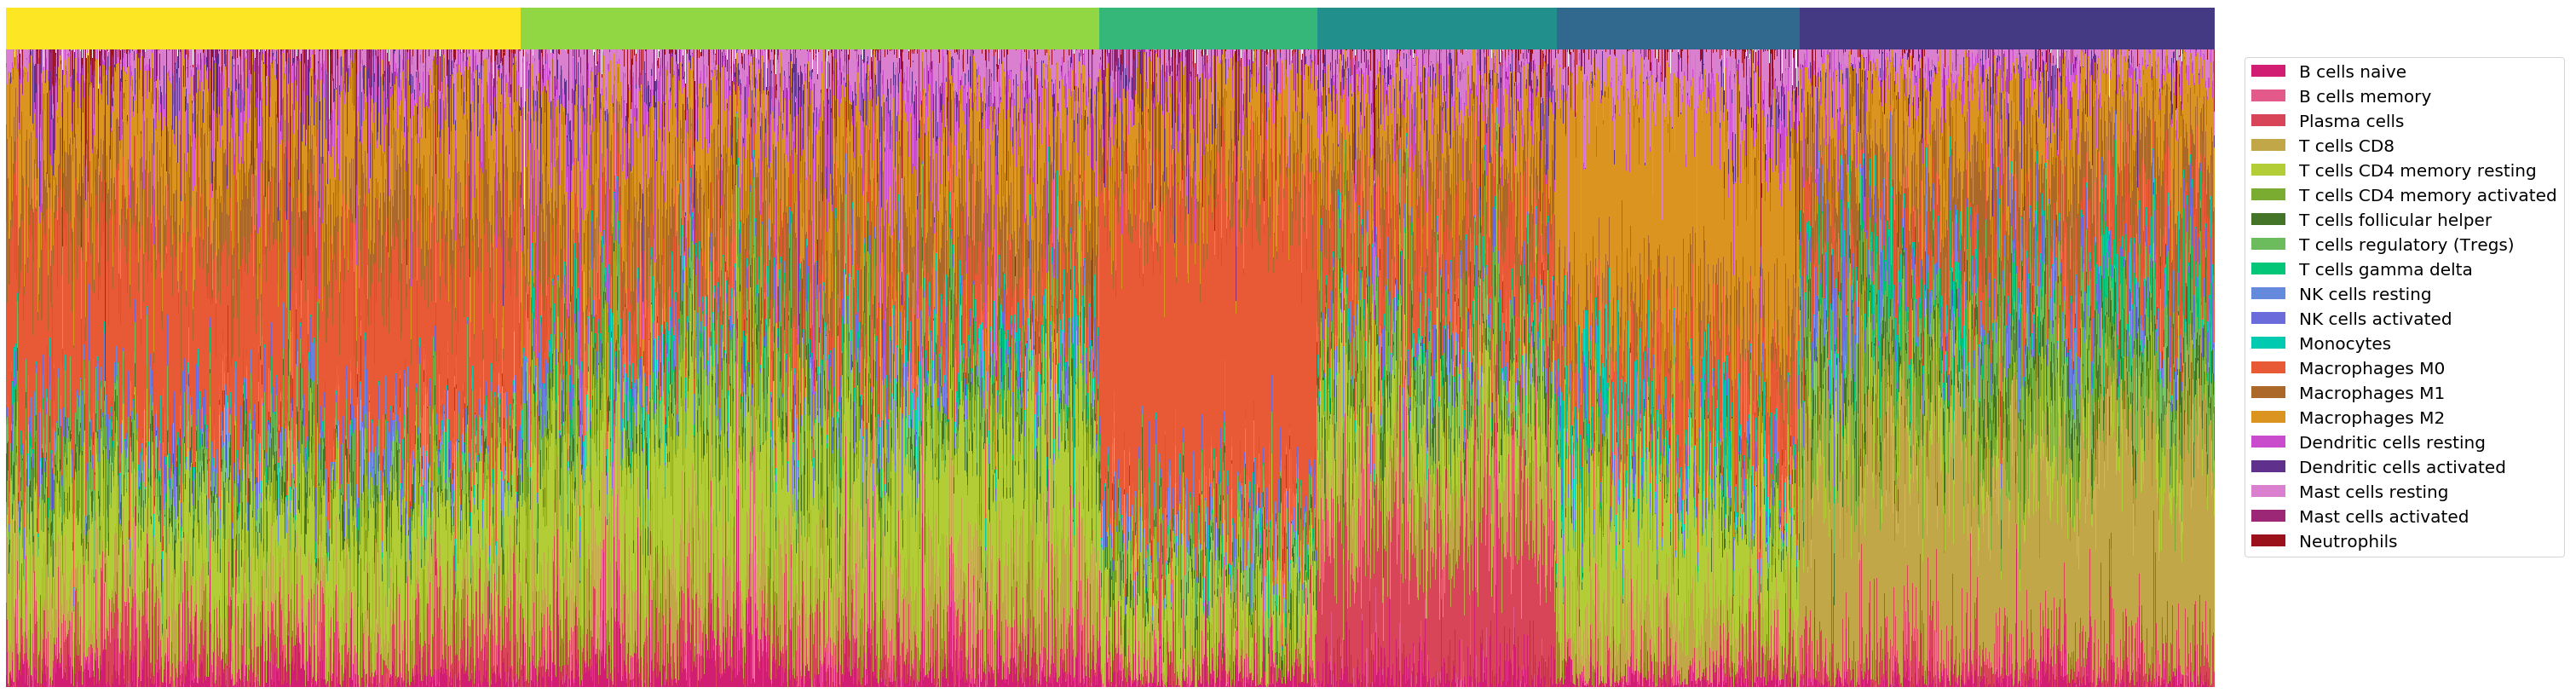

In [158]:
LEUC.stack_barplot(sorted_data,label,cell_label,cmap=color_ls)

In [62]:
colors = utils.read_color()         # read leukocyte color
cell_label=list(DF_filtered.columns)[1:]                                       # left cell
color_ls=colors.loc[cell_label].HEX.values   # select from all

## cluster in 5 group

In [390]:
from sklearn.manifold import TSNE

In [392]:
from sklearn.mixture import GaussianMixture as GMM

In [395]:
group5gmm =GMM(n_components=5,covariance_type='tied')

In [397]:
group5gmm.fit_predict(data)

array([2, 2, 2, ..., 2, 2, 2])

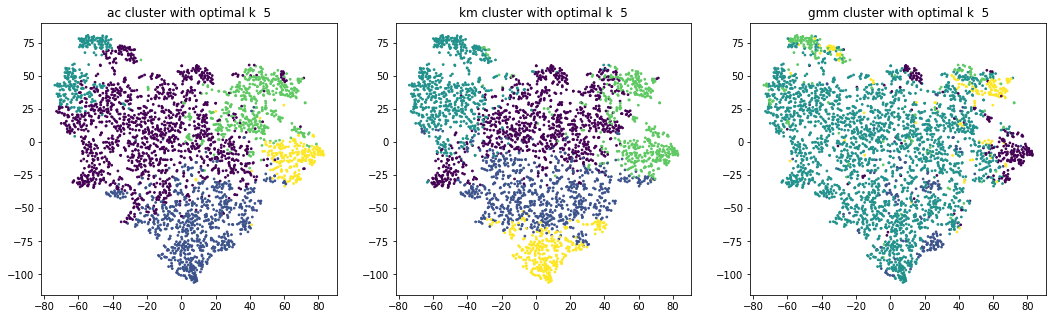

In [684]:
LEUC.t_sne_label(ALL_tsnes,labels,metrics,manual_vote=1)

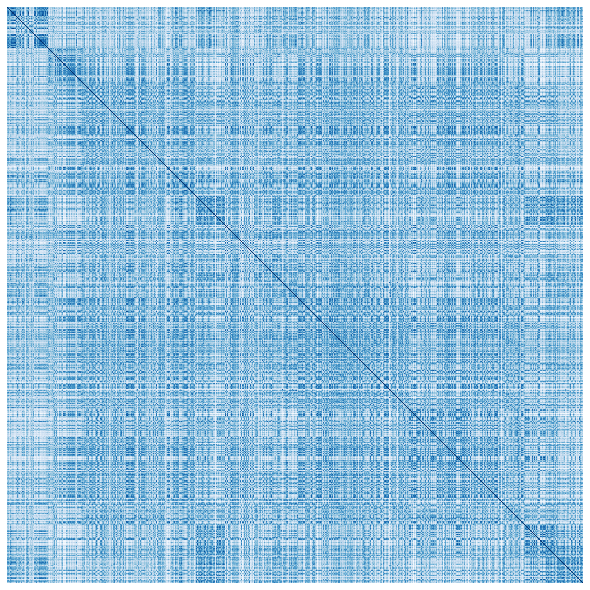

In [682]:
sorted_data,label = LEUC.sort_data_by_label(data,labels,metrics,method='gmm',manual_vote=1)

LEUC.tree_heatmap(sorted_data,None)

this will take several minutes


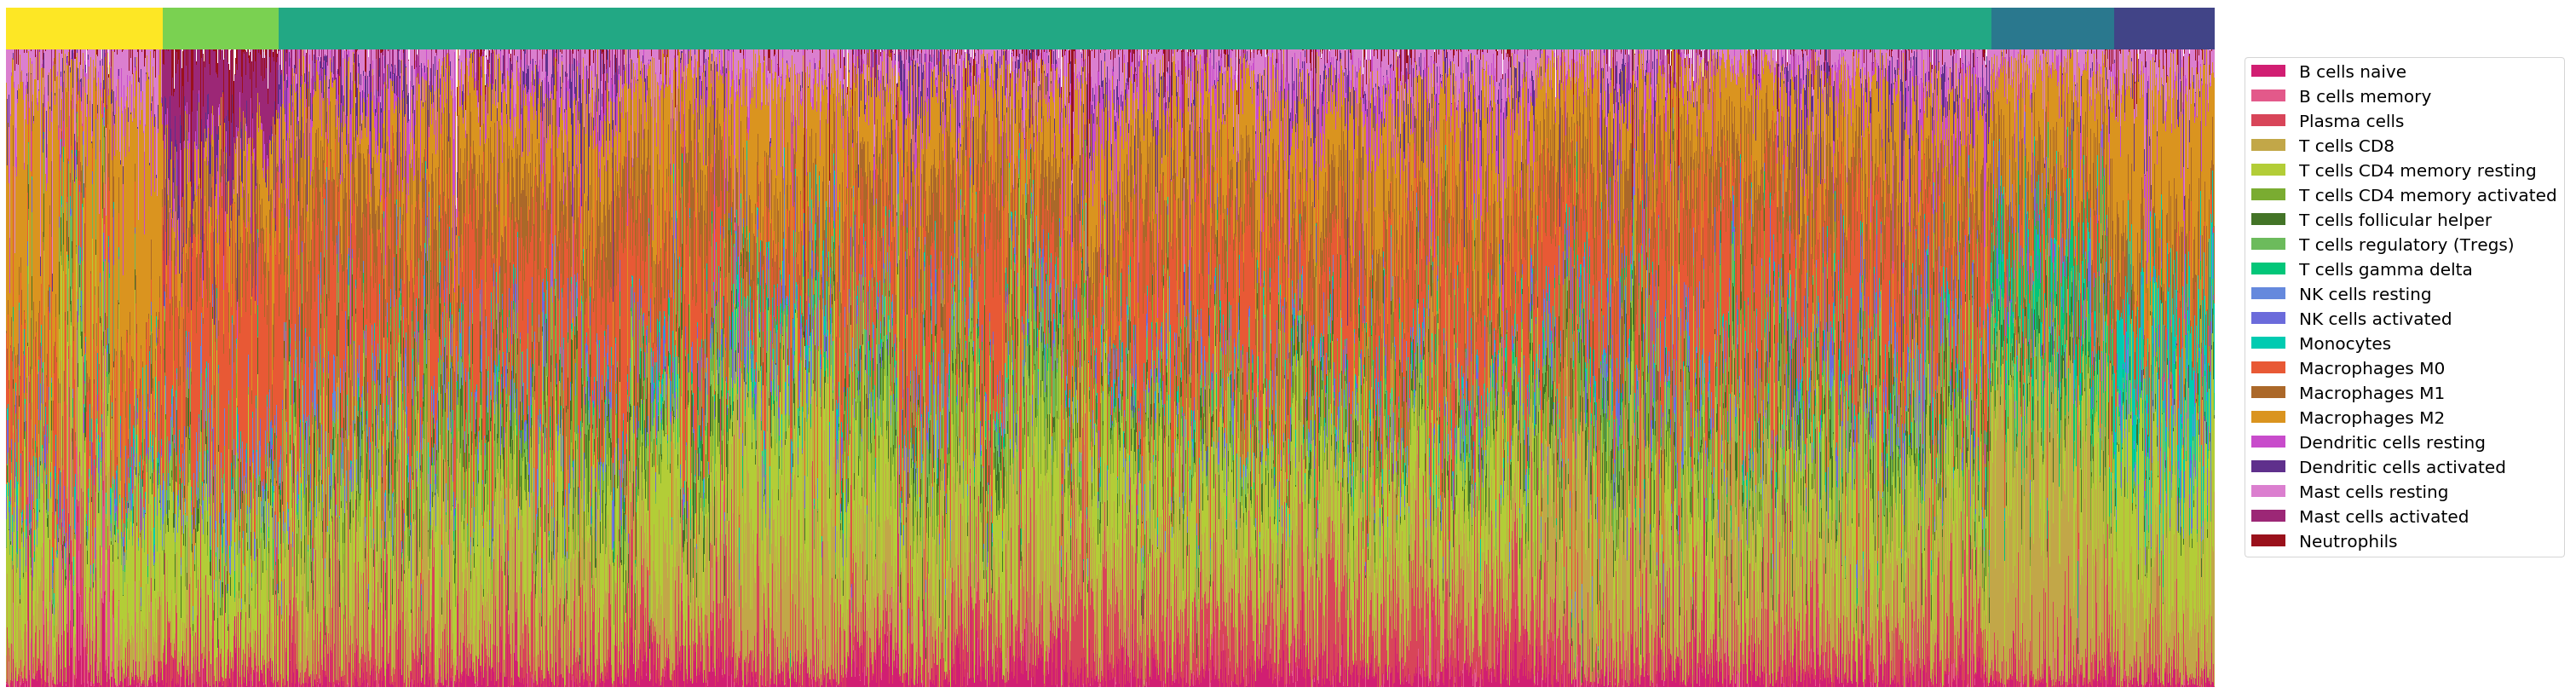

In [683]:
LEUC.stack_barplot(sorted_data,label,cell_label,cmap=color_ls)

#### cancaer type distribution

In [4]:
new_cancer_type = pd.read_csv(os.path.join(PATH.tsne_path,'ALL_tsnev2.csv'),index_col=0)

In [7]:
DF=utils.read_leukocyte(PATH.leukocyte_path,True,None)

In [8]:
DF.keys()

dict_keys(['KIC2', 'LIVER', 'MELANOMA', 'TNBC', 'BLADDER', 'COLON', 'HNSCC', 'NSCLC', 'CERVICAL', 'STOMACH'])

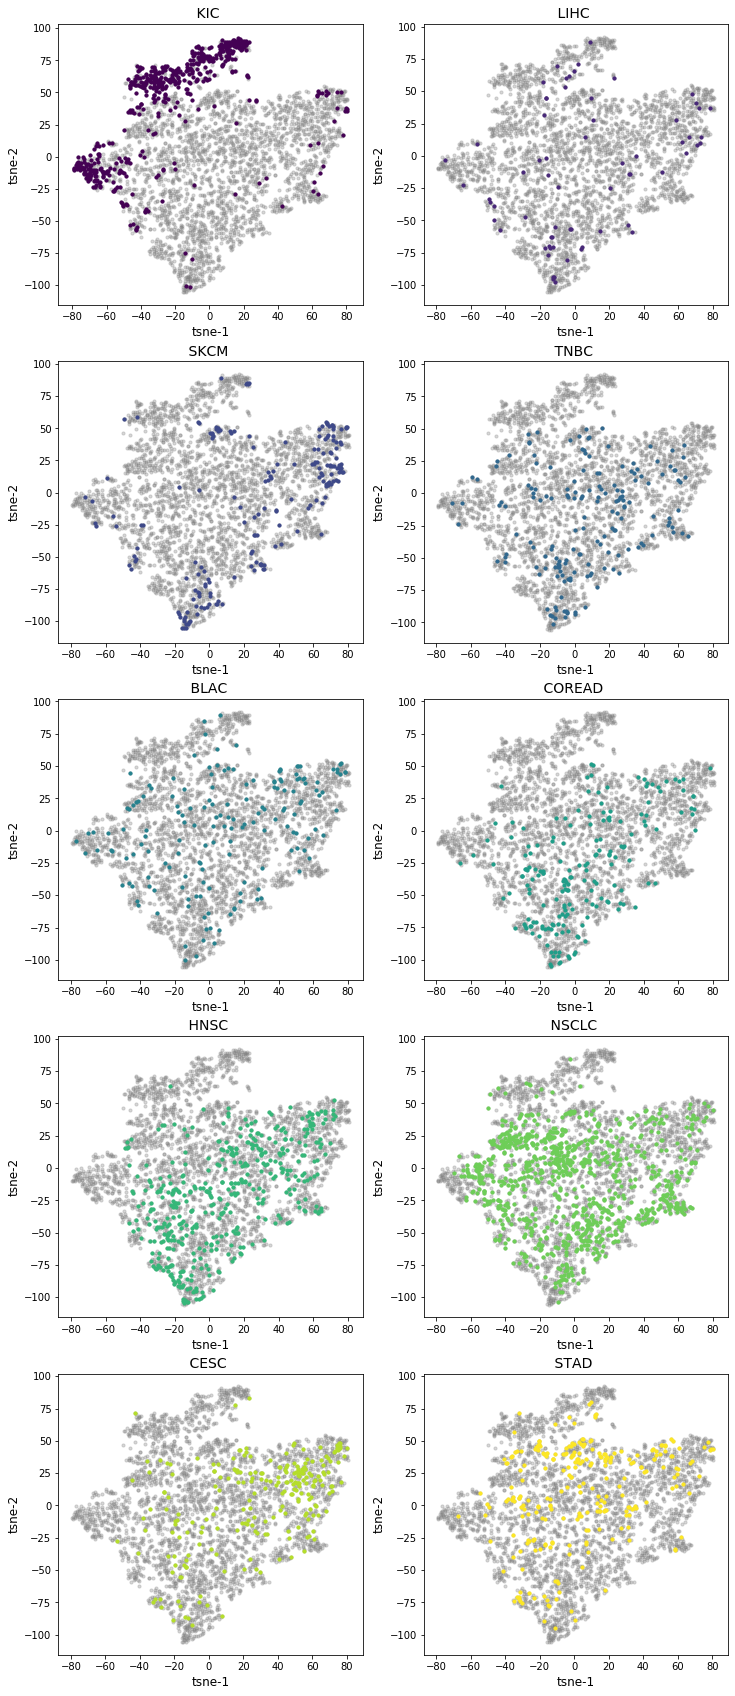

In [10]:
fig = plt.figure(figsize=(12,30))
i = 0
for cancer_type in DF.keys():
    ax = fig.add_subplot(5,2,i+1)
    local_DF,statistics = LEUC.statistics_preprocess(DF[cancer_type],False)
    LEUC.cluter_in_all_no_label(local_DF,cancer_type,ax=ax,**{'color':cm.viridis(i/9)})
    ax.set_title(' {}  '.format(utils.name_dict[cancer_type]),fontsize=14)
    i += 1

In [11]:
pdf = PdfPages('caner_type_distribution_v2.pdf')
pdf.savefig(fig)
pdf.close()

In [ ]:
%debug

# Survival analysis

In [102]:
from lifelines import KaplanMeierFitter

### data

In [93]:
# save the current cluster result

DF_2 = DF_filtered.copy()
DF_2.loc[:,'v2_c6'] = labels['km'][1]
DF_2.loc[:,'v2_c5'] = labels['km'][0]

DF_2.loc[:,['id','v2_c6','v2_c5']].to_csv(os.path.join(PATH.report_path,'cluster_label_v2.csv'),index=False)

In [640]:
# save the current cluster result
DF_3 = DF_filtered.copy()
for method in ['ac','km','gmm']:
    for i,n_cluster in enumerate(range(4,9)):
        DF_3.loc[:,method+str(n_cluster)] = labels[method][i]

# DF_3.loc[:,['id','ac6','ac5']].to_csv(os.path.join(PATH.report_path,'cluster_label_v2.csv'),index=False)

In [641]:
OS_EFS = pd.read_csv(os.path.join(PATH.data_path,'label','survival_time.csv')).drop(['Unnamed: 3'],axis=1)  # read csv data
OS_EFS.head(3)

A0_Samples    OS/month  A2_Event   EFS/month  A8_New_Event
0  TCGA-KM-8477   51.766667       0.0   51.766667             0
1  TCGA-UW-A7GG   44.233333       0.0   44.233333             0
2  TCGA-KO-8410  104.533333       0.0  104.533333             0

In [642]:
# seems like the id of OS EFS csv is only the first 12 letters
DF_3.loc[:,'A0_Samples'] = DF_3.id.apply(lambda x: x[:12])
interset_DF=OS_EFS.merge(DF_3.iloc[:,21:],right_on=['A0_Samples'],left_on=['A0_Samples']) 
# merge the DF to have the intersect

interset_DF=interset_DF.dropna()
interset_DF.head(3)

A0_Samples    OS/month  A2_Event   EFS/month  A8_New_Event  ac4  ac5  \
0  TCGA-KO-8414  107.066667       0.0  107.066667             0    0    3   
1  TCGA-KO-8404   10.833333       1.0    4.933333             1    0    4   
2  TCGA-KO-8405  101.866667       0.0  101.866667             0    0    4   

   ac6  ac7  ac8  km4  km5  km6  km7  km8  gmm4  gmm5  gmm6  gmm7  gmm8  
0    3    1    1    3    0    4    1    4     2     3     3     2     0  
1    4    4    4    2    3    2    2    6     3     0     4     3     3  
2    4    4    4    3    3    2    2    6     3     0     4     3     3

### KM

partition

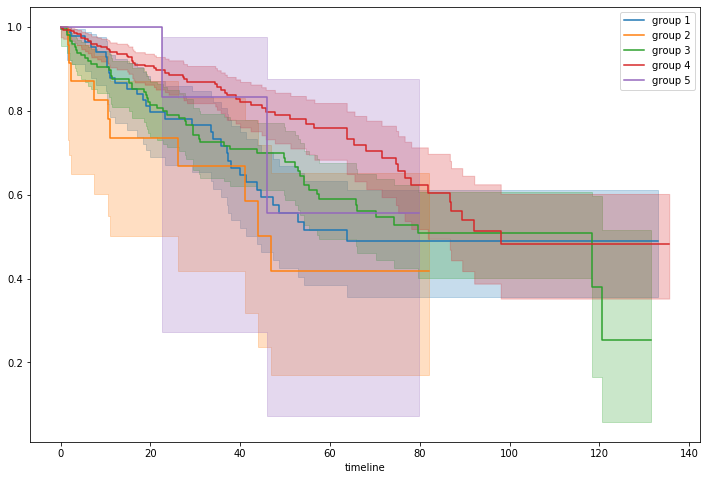

In [647]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca();
kmf_dic = {}
method = 'km'
n_cluster = 5
for i in range(n_cluster):
    kmf_dic[i] = KaplanMeierFitter()
    duration_i = interset_DF.loc[interset_DF[method+str(n_cluster)] == i,'OS/month']
    observe_i = interset_DF.loc[interset_DF[method+str(n_cluster)] == i,'A2_Event']
    kmf_dic[i].fit(duration_i,observe_i,label='group {}'.format(i+1))
#     kmf.survival_function_.plot(ax=ax)
    kmf_dic[i].plot(ax=ax)
    

In [156]:
np.sum(interset_DF.v2_c6 == 0)

225

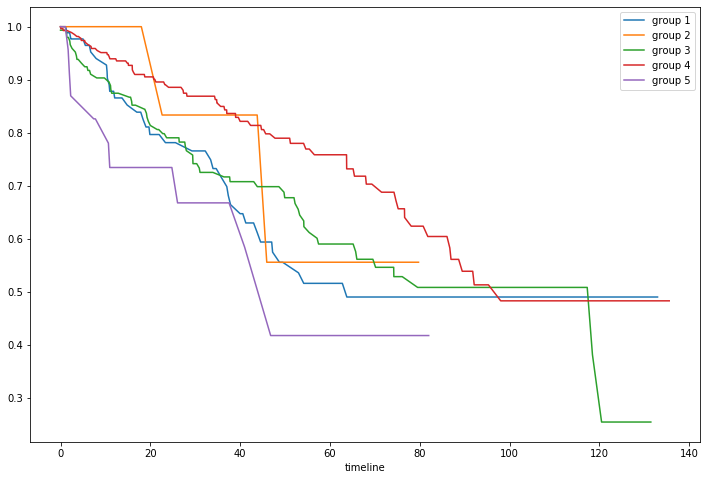

In [172]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca();
for i in range(5):
    duration_i = interset_DF.loc[interset_DF.v2_c5 == i,'OS/month']
    observe_i = interset_DF.loc[interset_DF.v2_c5 == i,'A2_Event']
    kmf.fit(duration_i,observe_i,label='group {}'.format(i+1))
    kmf.survival_function_.plot(ax=ax);

### AC

In [214]:
OS_EFS = pd.read_csv(os.path.join(PATH.data_path,'label','survival_time.csv')).drop(['Unnamed: 3'],axis=1)  # read csv data
OS_EFS.head(3)

A0_Samples    OS/month  A2_Event   EFS/month  A8_New_Event
0  TCGA-KM-8477   51.766667       0.0   51.766667             0
1  TCGA-UW-A7GG   44.233333       0.0   44.233333             0
2  TCGA-KO-8410  104.533333       0.0  104.533333             0

In [215]:
# seems like the id of OS EFS csv is only the first 12 letters
DF_3.loc[:,'A0_Samples'] = DF_3.id.apply(lambda x: x[:12])

In [216]:
interset_DF=OS_EFS.merge(DF_3[['A0_Samples','ac6','ac5']],right_on=['A0_Samples'],left_on=['A0_Samples']) 
# merge the DF to have the intersect

interset_DF.head(3)

A0_Samples    OS/month  A2_Event   EFS/month  A8_New_Event  ac6  ac5
0  TCGA-KO-8414  107.066667       0.0  107.066667             0    3    3
1  TCGA-KO-8404   10.833333       1.0    4.933333             1    4    4
2  TCGA-KO-8405  101.866667       0.0  101.866667             0    4    4

In [217]:
kmf = KaplanMeierFitter()

overall

In [218]:
interset_DF=interset_DF.dropna()

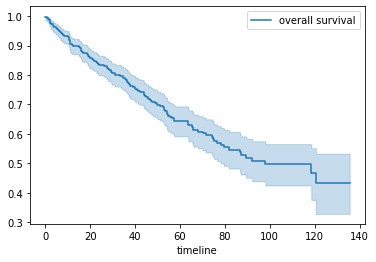

In [196]:
duration = interset_DF.loc[:,'OS/month']
observe = interset_DF.loc[:,'A2_Event']
kmf.fit(duration,observe,label='overall survival')

fig = plt.figure(figsize=(6,4))
ax = fig.gca();
kmf.plot(ax=ax);

partition

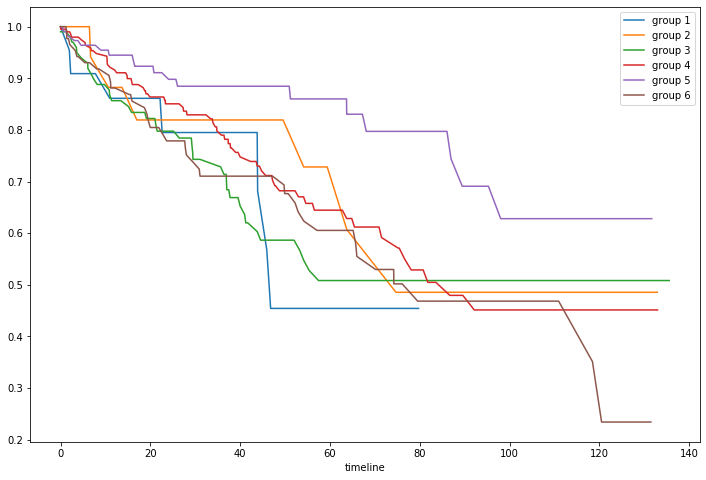

In [219]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca();
for i in range(6):
    duration_i = interset_DF.loc[interset_DF.ac6 == i,'OS/month']
    observe_i = interset_DF.loc[interset_DF.ac6 == i,'A2_Event']
    kmf.fit(duration_i,observe_i,label='group {}'.format(i+1))
    kmf.survival_function_.plot(ax=ax)

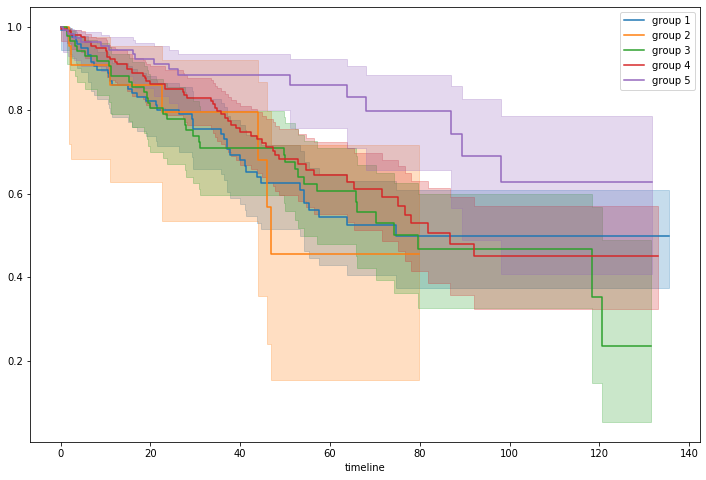

In [221]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca();
for i in range(5):
    duration_i = interset_DF.loc[interset_DF.ac5 == i,'OS/month']
    observe_i = interset_DF.loc[interset_DF.ac5 == i,'A2_Event']
    kmf.fit(duration_i,observe_i,label='group {}'.format(i+1))
#     kmf.survival_function_.plot(ax=ax);
    kmf.plot(ax=ax);

### gmm


In [637]:
# save the current cluster result
method = 'km'
DF_3 = DF_filtered.copy()
for i,n_cluster in enumerate(range(4,9)):
    DF_3.loc[:,method+str(n_cluster)] = labels[method][i]

# DF_3.loc[:,['id','ac6','ac5']].to_csv(os.path.join(PATH.report_path,'cluster_label_v2.csv'),index=False)

In [530]:
np.sum(DF_3.gmm5 == 2)

2445

In [638]:
OS_EFS = pd.read_csv(os.path.join(PATH.data_path,'label','survival_time.csv')).drop(['Unnamed: 3'],axis=1)  # read csv data
OS_EFS.head(3)

A0_Samples    OS/month  A2_Event   EFS/month  A8_New_Event
0  TCGA-KM-8477   51.766667       0.0   51.766667             0
1  TCGA-UW-A7GG   44.233333       0.0   44.233333             0
2  TCGA-KO-8410  104.533333       0.0  104.533333             0

In [639]:
# seems like the id of OS EFS csv is only the first 12 letters
DF_3.loc[:,'A0_Samples'] = DF_3.id.apply(lambda x: x[:12])
interset_DF=OS_EFS.merge(DF_3.iloc[:,21:],right_on=['A0_Samples'],left_on=['A0_Samples']) 
# merge the DF to have the intersect

interset_DF=interset_DF.dropna()
interset_DF.head(3)

A0_Samples    OS/month  A2_Event   EFS/month  A8_New_Event  km4  km5  \
0  TCGA-KO-8414  107.066667       0.0  107.066667             0    3    0   
1  TCGA-KO-8404   10.833333       1.0    4.933333             1    2    3   
2  TCGA-KO-8405  101.866667       0.0  101.866667             0    3    3   

   km6  km7  km8  
0    4    1    4  
1    2    2    6  
2    2    2    6

overall

partition

In [300]:
from scipy import stats

In [501]:
import math

In [376]:
np.ceil(kmf_dic[2].survival_function_.index.max() /14)

10.0

In [508]:
def generate_group_quantile(kmf_dic,n_interval=14):
    """
    for each group, generate survival frequancy of the fixed timestep
    ...kmf_dic : the dict type object, each element should be a kmf
    ...n_interval : the number of time windows
    """
    max_time = 0.0
    quantile = np.zeros((len(kmf_dic),n_interval),np.float64)  # the final array, raw : sample , columns : interval
    
    for i in kmf_dic.keys():
        max_time = max(max_time,kmf_dic[i].survival_function_.index.max())
    
    interval = np.ceil(max_time / n_interval)
    
    for i in kmf_dic.keys():
        DF = kmf_dic[i].survival_function_
        last_interval = int(DF.index.max() // interval) 
        # the maximum length of the certain df, after which will full of 0
        
        for itv in range(last_interval):
            count = np.mean(DF.loc[(DF.index > 10*itv)&(DF.index < 10*(itv+1))]) # take the mean value of those fall in these region
            
            # check nan
            if not math.isnan(count):
                quantile[i,itv] = count
            elif itv == 0:
                quantile[i,itv] = 1.0
            else:
                quantile[i,itv] = quantile[i,itv-1]
                
    return quantile

In [510]:
group_quantile = generate_group_quantile(kmf_dic)

In [517]:
distri = group_quantile[:,:-1] - group_quantile[:,1:]

In [518]:
np.sum(distri,axis=1)

array([0.99897119, 1.        , 0.94927029, 0.95329871, 0.97664892])

In [520]:
stats.chisquare(distri[0],distri[1])

Power_divergenceResult(statistic=nan, pvalue=nan)

In [524]:
np.sum(interset_DF[method+str(n_cluster)] == 0)

118

In [ ]:
def survival_curve(DF,method,n_clusters,duration_col='OS/month',observe_col='A2_Event',ax=None,plotting=True):
    """
    fit Kaplan-Meier model and plot the curve
    ...DF : the Data-frame containing both survival info (duration and observation) and 
    ...method : the cluster method : {'ac','km','gmm'}
    ...n_cluster : 
    """
    if ax is not None:
        fig = plt.figure(figsize=(12,8))
        ax = fig.gca();
    kmf_dic = {}
    for i in range(n_cluster):
        kmf_dic[i] = KaplanMeierFitter()
        duration_i = interset_DF.loc[interset_DF[method+str(n_cluster)] == i,'OS/month']
        observe_i = interset_DF.loc[interset_DF[method+str(n_cluster)] == i,'A2_Event']
        kmf_dic[i].fit(duration_i,observe_i,label='group {}'.format(i+1))
#         kmf.survival_function_.plot(ax=ax)
        if plotting:
            kmf_dic[i].plot(ax=ax)
    return kmf_dic

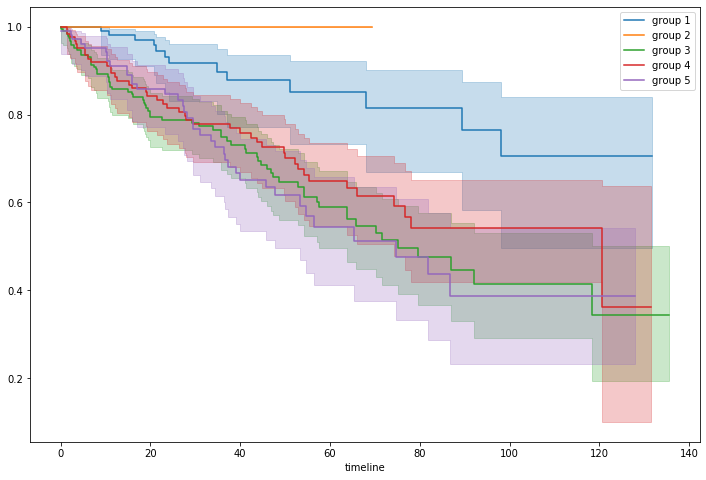

In [681]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca();
kmf_dic = {}
method = 'gmm'
n_cluster = 5
for i in range(n_cluster):
    kmf_dic[i] = KaplanMeierFitter()
    duration_i = interset_DF.loc[interset_DF[method+str(n_cluster)] == i,'OS/month']
    observe_i = interset_DF.loc[interset_DF[method+str(n_cluster)] == i,'A2_Event']
    kmf_dic[i].fit(duration_i,observe_i,label='group {}'.format(i+1))
#     kmf.survival_function_.plot(ax=ax)
    kmf_dic[i].plot(ax=ax)
    
# duration = interset_DF.loc[:,'OS/month']
# observe = interset_DF.loc[:,'A2_Event']
# kmf.fit(duration,observe,label='overall survival')
# kmf.plot(ax=ax);

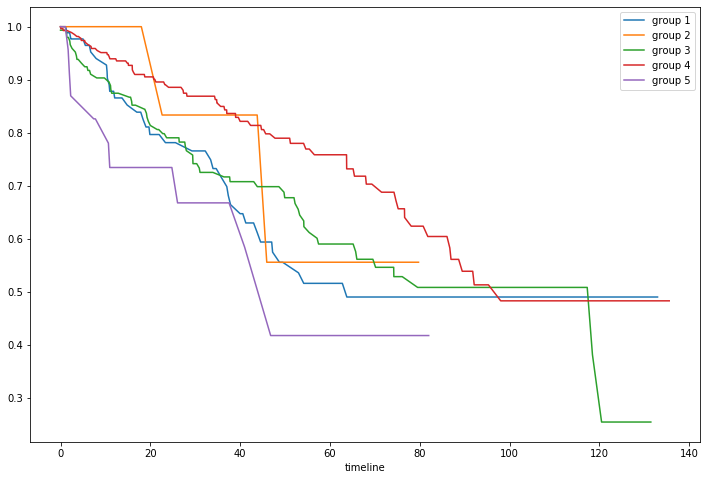

In [172]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca();
for i in range(5):
    duration_i = interset_DF.loc[interset_DF.v2_c5 == i,'OS/month']
    observe_i = interset_DF.loc[interset_DF.v2_c5 == i,'A2_Event']
    kmf.fit(duration_i,observe_i,label='group {}'.format(i+1))
    kmf.survival_function_.plot(ax=ax);

In [663]:
from lifelines import CoxPHFitter

In [661]:
def CoxPH_test(DF=interset_DF,group_to_test=[0,4],n_cluster=5,method='gmm'):
    df_ls = []
    for i,group in enumerate(group_to_test):
        duration_i = interset_DF.loc[interset_DF[method+str(n_cluster)] == group,'OS/month']
        observe_i = interset_DF.loc[interset_DF[method+str(n_cluster)] == group,'A2_Event']
        df_ls.append(pd.DataFrame({'duration':duration_i,'observe':observe_i,'group':i}))

    cpf_df = pd.concat(df_ls,axis=0)
    cpf = CoxPHFitter()
    cpf.fit(df=cph_df,duration_col='duration',event_col='observe')
    return cpf

In [662]:
CoxPH_test(interset_DF,[2,0],n_cluster=6)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [649]:
# result=CoxPH_test(interset_DF,[0,4]).print_summary()
for i in range(0,6):
    for j in range(i+1,6):
        cph=CoxPH_test(interset_DF,[i,j],n_cluster=6)
        print(cph.log_likelihood_ratio_test().p_value)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [634]:
cph.log_likelihood_ratio_test().p_value

0.263046937560852

In [655]:
cph =CoxPH_test(interset_DF,[3,2])

cph.plot()

TypeError: super(type, obj): obj must be an instance or subtype of type